#  ConvNet for the 2020s
### Reference
1. [paper](https://arxiv.org/abs/2201.03545)

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import losses

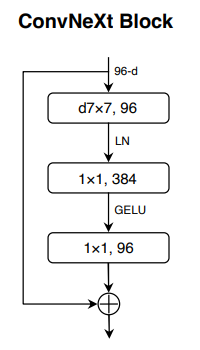

## ConvNeXt is different to existing CNN
1. GeLU
2. Layer Norm  
It appears after stem, before downsampling layer, after GAP layer
3. Seperate downsmaplnig layer
4. Kernel at the 1st layer dosen't overlap
5. Larger kernel size

In [2]:
class ConvBlock(layers.Layer):
    def __init__(
        self,
        stage,
        block,
        filter,
        config,
        name = 'ConvBlock',
        **kwargs
    ):
        super().__init__(name = name + f'{stage}-{block}')
        self.dwise = layers.DepthwiseConv2D(kernel_size = (3, 3),
                                            strides = (1, 1),
                                            padding = 'same',
                                            depthwise_initializer = initializers.VarianceScaling(2, 'fan_avg'),
                                            depthwise_regularizer = config.reg)
        self.ln = layers.LayerNormalization()
        self.conv1 = layers.Conv2D(filters = filter * 4,
                                   kernel_size = (1, 1),
                                   strides = (1, 1),
                                   padding = 'same',
                                   kernel_initializer = initializers.VarianceScaling(2, 'fan_avg'),
                                   kernel_regularizer = config.reg,
                                   activation=tf.nn.gelu)
        self.conv2 = layers.Conv2D(filters = filter,
                                   kernel_size = (1, 1),
                                   strides = (1, 1),
                                   padding = 'same',
                                   kernel_initializer = initializers.VarianceScaling(2, 'fan_avg'),
                                   kernel_regularizer = config.reg,)
       
    def call(self, X):
        x = self.conv2(self.conv1(self.ln(self.dwise(X))))
        return x + X

In [3]:
class Downsample(layers.Layer):
    def __init__(
        self,
        filter,
        config,
        name = 'DownSample',
        **kwargs
    ):
        super().__init__(name = name, **kwargs)
        self.ln = layers.LayerNormalization()
        self.conv = layers.Conv2D(filters = filter,
                                  kernel_size = (2, 2),
                                  strides = (2, 2),
                                  padding = 'valid',
                                  kernel_initializer = initializers.VarianceScaling(2, 'fan_avg'),
                                  kernel_regularizer = config.reg)
        
    def call(self, X):
        return self.conv(self.ln(X))

In [57]:
class NetworkStem(layers.Layer):
    def __init__(
        self,
        filters,
        config,
        name = 'NetworkStem',
        **kwargs
    ):
        super().__init__(name = name, **kwargs)
        self.conv = layers.Conv2D(filters = architecture.get('filters')[0],
                                  kernel_size = (2, 2),
                                  strides = (2, 2),
                                  padding = 'valid',
                                  kernel_initializer = initializers.VarianceScaling(2, 'fan_avg'),
                                  kernel_regularizer = config.reg)
        self.ln = layers.LayerNormalization()

    def call(self, X):
        return self.ln(self.conv(X))

In [4]:
class NetworkHead(layers.Layer):
    def __init__(
        self,
        num_class,
        config,
        name = 'NetworkHead',
        **kwargs
    ):
        super().__init__(name = name, **kwargs)
        self.ln = layers.LayerNormalization()
        self.gap = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(units = num_class,
                               kernel_initializer = initializers.VarianceScaling(2, 'fan_avg'),
                               kernel_regularizer = config.reg)

    def call(self, X):
        return self.fc(self.gap(self.ln(X)))

In [60]:
class ConvNeXt(models.Model):
    def __init__(
        self,
        architecture,
        config,
        name = 'ConvNeXt',
        **kwargs
    ):
        '''architecture = {"filters": [32, 64],
                            "blocks": [3, 3],
                            "num_class": 10}
        '''
        super().__init__(name = name, **kwargs)
        self.net_layers = []
        self.net_layers.append(NetworkStem(architecture.get('filters')[0], config))
        for stage, (filter, blocks) in enumerate(zip(architecture.get('filters'),
                                                     architecture.get('blocks'))):
            for block in range(blocks):
                self.net_layers.append(ConvBlock(stage, block, filter, config))
            if stage + 1 < len(architecture.get('blocks')):
                self.net_layers.append(Downsample(architecture.get('filters')[stage+1], config))
        
        self.net_layers.append(NetworkHead(architecture.get('num_class'), config))
    
    def call(self, X, training = None):
        x = X
        for layer in self.net_layers:
            x = layer(x)
        return x

In [61]:
class Config:
    epochs = 10
    lr = 0.01
    weight_decay = 0.001
    reg = regularizers.L2(weight_decay)
    opt = optimizers.Adam(lr)
    loss = losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = metrics.SparseCategoricalAccuracy()

In [62]:
x = tf.random.normal(shape = [1, 32, 32, 3])
architecture = {"filters": [32, 64],
                "blocks": [3, 3],
                "num_class": 10}
convnext = ConvNeXt(architecture, Config)

In [ ]:
convnext(x)

(1, 16, 16, 32)
(1, 16, 16, 32)
(1, 16, 16, 32)
(1, 16, 16, 32)
(1, 8, 8, 64)
(1, 8, 8, 64)
(1, 8, 8, 64)
(1, 8, 8, 64)
(1, 10)


<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.137922  ,  0.25450888, -0.17713983, -0.6362249 , -0.5785674 ,
         0.01661984,  0.55331457,  0.92020196, -0.31321678, -0.09561554]],
      dtype=float32)>

In [8]:
from math import cos, pi

class CosineDecay:
    def __init__(
        self,
        init_lr,
        decay_step = 2,
        alpha = 0
    ):
        self.init_lr = init_lr
        self.decay_step = decay_step
        self.alpha = alpha

    def policy(self, step):
        step = min(step, self.decay_step)
        cos_decay = 0.5 * (1 + cos(pi * step / self.decay_step))
        decayed = (1 - self.alpha) * cos_decay - self.alpha 
        return self.init_lr * decayed

    def __call__(self, step):
        return self.policy(step)

In [63]:
from tqdm.notebook import tqdm

@tf.function
def train_loop(model, feature, label, optimizer, loss, metric):
    with tf.GradientTape() as tape:
        y_pred = model(feature, training = True)
        train_loss = loss(label, y_pred)
    trainable = model.trainable_weights
    grads = tape.gradient(train_loss, trainable)
    optimizer.apply_gradients(zip(grads, trainable))
    metric.update_state(label, y_pred)
    return train_loss

@tf.function
def test_loop(model, feature, label, loss, metric):
    y_pred = model(feature, training = False)
    val_loss = loss(label, y_pred)
    metric.update_state(label, y_pred)
    return val_loss

def train(model, train_ds, epochs, optimizer, loss, metric, regularizer = None, val_ds = None):
    log = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
    init_lr = Config.lr
    init_wd = Config.weight_decay
    for epoch in range(epochs):
        
        with  tqdm(train_ds, unit = ' step') as t_epoch:
            t_epoch.set_description(f'Epoch {epoch+1}')
            for step, (feature, label) in enumerate(t_epoch):
                train_loss = train_loop(model, feature, label, optimizer, loss, metric)
                train_acc = metric.result()                
                t_epoch.set_postfix({'loss': train_loss.numpy(), 'acc': train_acc.numpy() })

            log['loss'].append(train_loss.numpy())
            log['acc'].append(train_acc.numpy())
            metric.reset_states()
               
            if val_ds:
                for step, (feature, label) in enumerate(val_ds):
                    val_loss = val_loop(model, feature, label, loss, metric)
                    val_acc = metric.result()
                log['val_loss'].append(val_loss.numpy())
                log['val_acc'].append(val_acc.numpy())
                print(f'val_loss: {val_loss}         val)acc: {val_acc}')
                metric.reset_states()

            optimizer.lr = CosineDecay(init_lr = init_lr, decay_step = 20)(epoch)
            regularizer.l2 = CosineDecay(init_lr = init_wd, decay_step = 20)(epoch)
   
    return log

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


In [12]:
ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).cache()
ds = ds.map(lambda x, y: ((tf.cast(x, tf.float32) - tf.constant([125.3069 , 122.95015, 113.866  ])) / tf.constant([70.49192, 68.40918, 68.15831]), y))
ds = ds.shuffle(1000)
ds = ds.batch(batch_size = 128).prefetch(1)

In [64]:
log = train(convnext,
            ds,
            epochs = Config.epochs,
            optimizer = Config.opt,
            loss = Config.loss,
            metric = Config.metric,
            regularizer = Config.reg)

  0%|          | 0/391 [00:00<?, ? step/s]

  0%|          | 0/391 [00:00<?, ? step/s]

  0%|          | 0/391 [00:00<?, ? step/s]

  0%|          | 0/391 [00:00<?, ? step/s]

  0%|          | 0/391 [00:00<?, ? step/s]

  0%|          | 0/391 [00:00<?, ? step/s]

  0%|          | 0/391 [00:00<?, ? step/s]

  0%|          | 0/391 [00:00<?, ? step/s]

  0%|          | 0/391 [00:00<?, ? step/s]

  0%|          | 0/391 [00:00<?, ? step/s]

In [67]:
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).cache()
test_ds = test_ds.map(lambda x, y: ((tf.cast(x, tf.float32) - tf.constant([125.3069 , 122.95015, 113.866  ])) / tf.constant([70.49192, 68.40918, 68.15831]), y))
test_ds = test_ds.shuffle(1000)
test_ds = test_ds.batch(batch_size = len(x_test)//10)

In [75]:
def test(model, test_ds, loss, metric):
    with tqdm(test_ds, unit = ' step') as pbar:
        pbar.set_description('Progress: ')
        for step, (feature, label) in enumerate(pbar):
            y_pred = model(feature, training = False)
            test_loss = loss(label, y_pred)
            metric.update_state(label, y_pred)
            pbar.set_postfix({'test_loss': test_loss.numpy(), 'test_acc':metric.result().numpy()})

In [76]:
test(convnext, test_ds, Config.loss, Config.metric)

  0%|          | 0/10 [00:00<?, ? step/s]

In [85]:
print(f'Initial LR: {Config.lr}                     Initial WD: {Config.weight_decay}')
print(f'Last LR: {Config.opt.lr.numpy()}        Last WD: {Config.reg.l2}')

Initial LR: 0.01                     Initial WD: 0.001
Last LR: 0.005782172549515963        Last WD: 0.0005782172325201155
